In [1]:
from ftplib import FTP
import os
import zipfile
#import gzip
#import tarfile
from pprint import pprint
import io
import pandas
import numpy as np
import time
from IPython.display import display, HTML
import geopandas
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches


from shapely.ops import unary_union
from shapely.geometry import Point, Polygon, box
from matplotlib.patches import FancyBboxPatch, BoxStyle
#import re
from matplotlib.path import Path

# #these_states_dict = {'FL': {}, 'MD': {}}
these_states_dict = {'AK': {}, 
                     'WY': {}, 
                     'ND': {}, 
                     'SD': {}, 
                     'DE': {}, 
                     'VT': {},
                     'HI': {},
                     'ID': {},
                     'MT': {},
                     'WV': {},
                     'RI': {},
                     'NH': {},
                     'ME': {}
                    }
                     

pop_total_denominator = 330759736
nDistricts = 435
target = pop_total_denominator / nDistricts


g = 0
scale = 20
map_buffer_ratio = .1
main_map_crs = 102003 #{'init': 'epsg:9822'}
equal_area_crs = 2163  # An equal area projection: https://epsg.io/2163
desired_pct_area_overlap = 0.5

show_water = True
show_roads = False
water_area_tol = 100 * 1000 * 1000

#print('Target: each district should contain {0:,.0f} people!'.format(target))
print('ok')

ok


In [2]:
s = time.time()
script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
census_script_dir = '/home/idies/workspace/Storage/raddick/census/'
basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/'
shapefile_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/2020/'
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'

district_color_cycle = ['black', 'red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite', 'cornflowerblue', 'darkseagreen', 'thistle', 'tomato', 'silver', 'blueviolet', 'olive', 'peru', 'dodgerblue']
district_color_cycle += district_color_cycle
district_color_cycle += district_color_cycle

district_contrast_color_cycle = ['black', 'green', 'red', 'navy', 'black', 'purple', 'lime', 'black', 'red', 'red', 'black', 'red', 'black', 'black', 'white', 'yellow', 'yellow', 'yellow', 'yellow']
district_contrast_color_cycle += district_contrast_color_cycle
district_contrast_color_cycle += district_contrast_color_cycle

os.chdir(basedir)
e = time.time()
g += (e-s)
print('Now in directory: {0:}'.format(basedir))

Now in directory: /home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/


In [3]:
print('setting up infrastructure to plot roads...')
# we may derive from matplotlib.patches.BoxStyle._Base class.
# You need to override transmute method in this case.
class shield(BoxStyle._Base):
    """
    A simple box.
    """

    def __init__(self, pad=0.3):
        """
        The arguments need to be floating numbers and need to have
        default values.

         *pad*
            amount of padding
        """

        self.pad = pad
        super().__init__()

    def transmute(self, x0, y0, width, height, mutation_size):
        """
        Given the location and size of the box, return the path of
        the box around it.

         - *x0*, *y0*, *width*, *height* : location and size of the box
         - *mutation_size* : a reference scale for the mutation.

        Often, the *mutation_size* is the font size of the text.
        You don't need to worry about the rotation as it is
        automatically taken care of.
        """

        # padding
        pad = mutation_size * self.pad

        # width and height with padding added.
        width, height = width + 2.*pad, \
                        height + 2.*pad,

        # boundary of the padded box
        x0, y0 = x0-pad, y0-pad,
        x1, y1 = x0+width, y0 + height

        cp = [(0.5*(x0+x1), (y0-2.*pad)), # bottom
              (x1, y0),  # right lower-mid
              (x1+pad, (y0+y1)/2.),  # far right mid
              (x1, y1+pad),  # top right corner
              ((x0+x1)/2,y1),  # dip from top
              (x0, y1+pad),  # top left corner
              (x0-pad, (y0+y1)/2.),    # far left mid
              (x0, y0),  # left lower-mid
              ((x0+x1)/2., (y0-2.*pad)),  # return to bottom
              ((x0+x1)/2., (y0-2.*pad))]
        
        
        com = [Path.MOVETO,  # start
               Path.CURVE4, # curve to right mid
               Path.LINETO,  # line to far right mid
               Path.LINETO, # line to top right corner
               Path.CURVE3,  # line to dip
               Path.LINETO,  # line to top left corner
               Path.CURVE4,   # curve to far left mid
               Path.LINETO,   # line to left lower-mid
               Path.LINETO,
               Path.CLOSEPOLY]

        path = Path(cp, com)

        return path

BoxStyle._style_list["shield"] = shield



def parse_road_name(thename):
    try:
        annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
    except AttributeError:
        try: 
            annotator = thisrow['FULLNAME'][re.search('Hwy',thisrow['FULLNAME']).end():]
        except AttributeError:
            annotator = thisrow['FULLNAME']
    return annotator


road_label_format = { 
    'I': { 'labelsize': 16, 'thecolor': 'yellow', 'thebbox': dict(boxstyle="shield", fc='blue', ec='orange') },     
    'U': { 'labelsize': 14, 'thecolor': 'black', 'thebbox': dict(boxstyle="shield", fc='white', ec='black') },
    'S': { 'labelsize': 12, 'thecolor': 'black', 'thebbox': dict(boxstyle="square,pad=0.25", fc='white', ec='black')},
    'C': { 'labelsize': 10, 'thecolor': 'black', 'thebbox': dict(boxstyle="sawtooth,pad=0.5", fc='white') }, 
    'M': { 'labelsize': 16, 'thecolor': 'black'},
    'O': { 'labelsize': 11, 'thecolor': 'yellow' }
}
print('Done!')



setting up infrastructure to plot roads...
Done!


In [4]:
s = time.time()
# print('Getting data from FTP...')

# ftp = FTP('ftp2.census.gov')
# ftp.login()
# print(ftp.getwelcome())

# ftp.cwd('programs-surveys/decennial/2020/data/01-Redistricting_File--PL_94-171/')
# for thisdir in [x for x in ftp.nlst() if (('.pdf' not in x) and ('.doc' not in x))]:
#     print('Retrieving {0:}...'.format(thisdir))
#     zipfiles = [x for x in ftp.nlst(thisdir)]
#     for thisfile in zipfiles:
#         with io.open(thisfile.split('/')[1].lower(), 'wb') as f:
#              ftp.retrbinary('RETR {0:}'.format(thisfile), f.write)
# ftp.quit()
# print('Done')

# os.listdir()
#os.getcwd()
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('Retrieved files from Census FTP!')

Retrieved files from Census FTP!


In [5]:
s = time.time()
# for thisfile in os.listdir():
#     with zipfile.ZipFile(thisfile, 'r') as z:
#         print('Extracting {0:}...'.format(thisfile))
#         z.extractall()
# for thisfile in [x for x in os.listdir() if ('zip' in x)]:
#     os.remove(thisfile)
# print('Done!')
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('Unzipped files!')

Unzipped files!


# How many districts per state?

In [6]:
state_seats_df = pandas.read_csv(script_dir+'state_seats.csv', index_col='state_name')

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
#state_codes_df.columns = [x.lower() for x in state_codes_df.columns]
state_codes_df = state_codes_df.set_index('STATE_NAME')

#bg_df = bg_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

# state_seats_df = state_seats_df.reset_index().merge(
#     geo_df[geo_df['SUMLEV'] == 40][['STATE', 'STUSAB', 'NAME']], how='left', 
#     left_on='state_name', right_on='NAME'
# )[['STATE', 'STUSAB', 'seats_old', 'seats_new']].set_index('STATE').sort_index()

# print('Found new numbers of districts for {0:,.0f} states!'.format(len(state_seats_df)))
#state_seats_df
#geo_df[geo_df['SUMLEV'] == 40][['STATE', 'STUSAB', 'NAME']]

state_seats_df = state_seats_df.join(state_codes_df).set_index('STATE').sort_index()

print('Got old and new numbers of districts for {0:,.0f} states in {1:.1f} seconds!'.format(len(state_seats_df), e-s))

for this_state in these_states_dict.keys():
    these_states_dict[this_state]['STATEFP'] = state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]    
    these_states_dict[this_state]['seats_old'] = state_seats_df[state_seats_df['STUSAB'] == this_state]['seats_old'].values[0]
    these_states_dict[this_state]['seats_new'] = state_seats_df[state_seats_df['STUSAB'] == this_state]['seats_new'].values[0]
#pprint(these_states_dict)
print('\n')
print('Got old and new numbers of districts for {0:,.0f} focus states in {1:.1f} seconds!'.format(len(these_states_dict), e-s))



looking up state names from numbers...
Got old and new numbers of districts for 50 states in 0.0 seconds!


Got old and new numbers of districts for 13 focus states in 0.0 seconds!


# Read summary levels

In [7]:
s = time.time()
print('setting up summary levels...')
sumlevel_df = pandas.read_excel(script_dir+'sumlevel.xlsx')
sumlevel_df = sumlevel_df.rename(columns={'sumlevel': 'SUMLEV'})
sumlevel_df.index.name = 'rownumber'
#sumlevel_df = sumlevel_df.set_index('SUMLEV')
e = time.time()
g += (e-s)
print('Read descriptions for {0:,.0f} summary levels in {1:.1f} seconds!'.format(len(sumlevel_df), e-s))
#sumlevel_df


setting up summary levels...
Read descriptions for 85 summary levels in 0.1 seconds!


In [8]:
# print('getting states...')
# state_all_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_state.shp')
# state_all_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(state_all_gdf['STATEFP'], errors='coerce')
# #state_gdf = state_gdf[state_gdf['STATEFP'].isin(state_numbers_include_list)]
# #state_all_gdf[~state_all_gdf['STUSPS'].isin(['DC', 'PR', 'MP', 'VI', 'AS', 'GU'])][['STATEFP', 'STUSPS', 'NAME']].sort_values(by='STUSPS')
# state_all_gdf.columns


# Read redistricting geo data

In [9]:
s = time.time()
print('reading redistricting geography data for all states...')
geofiles = []

allgeofiles = [x for x in os.listdir() if (('geo' in x) and (x[-3:] == '.pl') and (x[:2] not in ['dc', 'pr', 'mp', 'vi', 'as', 'gu']))]
for this_focus_state in list(these_states_dict.keys()):
    geofiles += [x for x in allgeofiles if x[0:2] == this_focus_state.lower()]
    #geofiles.append([x for x in geofiles if x[0:2] == this_focus_state.lower()])

geo_df = pandas.DataFrame()

for thisfile in geofiles:
    print('\treading {0:}...'.format(thisfile))
    geo_df_i = pandas.read_csv(thisfile, sep='|', header=None, low_memory=False, encoding='ISO-8859-1')#, encoding='utf-8')
    geo_df = pandas.concat((geo_df, geo_df_i), axis=0)
    
print('renaming columns...')
column_names = []
column_names += ['FILEID', 'STUSAB', 'SUMLEV', 'GEOVAR', 'GEOCOMP', 'CHARITER', 'CIFSN', 'LOGRECNO', 'GEOID']
column_names += ['GEOCODE', 'REGION', 'DIVISION', 'STATE', 'STATENS', 'COUNTY', 'COUNTYCC', 'COUNTYNS']
column_names += ['COUSUB', 'COUSUBCC', 'COUSUBNS']
column_names += ['SUBMCD', 'SUBMDCC', 'SUBMCDNS', 'ESTATE', 'ESTATECC', 'ESTATENS']
column_names += ['CONCIT', 'CONCITCC', 'CONCITNS', 'PLACE','PLACECC', 'PLACENS']
column_names += ['TRACT', 'BLKGRP', 'BLOCK']
column_names += ['AIANHH', 'AIANHHLI', 'AIANHHFP', 'AIANHHCC', 'AIANHHNS', 'AITS', 'AITSFP', 'AITSCC', 'AITSNS']
column_names += ['TTRACT', 'TBLKGRP', 'ANRC', 'ANRCCC', 'ARNCNS']
column_names += ['CBSA', 'MEMI', 'CSA', 'METDIV']
column_names += ['NECTA', 'NMEMI', 'CNECTA', 'NECTADIV']
column_names += ['CBSAPCI', 'NECTAPCI', 'UA', 'UATYPE', 'UR']
column_names += ['CD116', 'CD118', 'CD119', 'CD120', 'CD121']
column_names += ['SLDU18', 'SLDU22', 'SLDU24', 'SLDU26', 'SLDU28']
column_names += ['SLDL18', 'SLDL22', 'SLDL24', 'SLDL26', 'SLDL28']
column_names += ['VTD', 'VTDI', 'ZCTA', 'SDELM', 'SDSEC', 'SDUNI', 'PUMA']
column_names += ['AREALAND', 'AREAWATER', 'BASENAME', 'NAME', 'FUNCSTAT', 'GCUNI']
column_names += ['POP100', 'HU100']
column_names += ['INTPTLAT', 'INTPTLON', 'LSADC', 'PARTFLAG', 'UGA']

# for i in range(0, len(column_names)):    
#     if (np.isnan(pandas.to_numeric(column_names[i], errors='coerce'))):
#         geo_df = geo_df.rename(columns = {i: column_names[i]})
#     else:
#         geo_df = geo_df.rename(columns = {i: int(column_names[i])})

geo_df.columns = column_names

print('\tTotal columns: {0:.0f}'.format(len(geo_df.columns)))
print('\tNamed columns: {0:.0f}'.format(len(column_names)))

geo_df = geo_df.set_index('GEOID')


# print('finding stuff...')
# mycol = 'UGA'
# showcolumns = []
# showcolumns += ['SUMLEV', mycol]
#geo_df[geo_df[mycol].notnull()][showcolumns]
#print('done')

# geo_df.merge(sumlevel_df, how='left', on='SUMLEV')
# geo_df.set_index('SUMLEV')
# print('adding summary level descriptions...')
# geo_df = geo_df.reset_index().merge(sumlevel_df, how='left', on='SUMLEV').set_index('GEOID')
# geo_df = geo_df.rename(columns={'description': 'sumlev_description'})

#geo_df
e = time.time()
g += (e-s)
print('\n')
print('Read {0:,.0f} geographies in {1:.0f} minutes {2:.0f} seconds!'.format(len(geo_df), np.floor((e-s)/60), (e-s)%60))


reading redistricting geography data for all states...
	reading akgeo2020.pl...
	reading wygeo2020.pl...
	reading ndgeo2020.pl...
	reading sdgeo2020.pl...
	reading degeo2020.pl...
	reading vtgeo2020.pl...
	reading higeo2020.pl...
	reading idgeo2020.pl...
	reading mtgeo2020.pl...
	reading wvgeo2020.pl...
	reading rigeo2020.pl...
	reading nhgeo2020.pl...
	reading megeo2020.pl...
renaming columns...
	Total columns: 97
	Named columns: 97


Read 901,588 geographies in 0 minutes 56 seconds!


In [10]:
s = time.time()
print('counting by summary level...')
count_df = pandas.DataFrame(data=None, columns=['sumlev_description', 'count', 'pop'], index=sumlevel_df['SUMLEV'].tolist())
count_df.index.name = 'SUMLEV'
count_df.loc[:, 'sumlev_description'] = sumlevel_df.set_index('SUMLEV')['description']
count_df.loc[:, 'count'] = geo_df.groupby('SUMLEV').size()
count_df.loc[:, 'pop'] = geo_df.groupby('SUMLEV')['POP100'].sum()
#count_df
nan_levels = count_df[count_df['count'].isnull()].index.tolist()

htmlstr = ''
htmlstr += '<table>'
htmlstr += '<tr>'
htmlstr += '<th>SUMLEVEL</th>'
for thiscol in count_df.columns.tolist():    
    htmlstr += '<th>{0:}</th>'.format(thiscol)
htmlstr += '</tr>'

for sumlev, thisrow in count_df.iterrows():
    #if ('remainder' not in thisrow['sumlev_description'].lower()):
    if (sumlev not in nan_levels):
        htmlstr += '<tr>'    
        htmlstr += '<td>{0:3d}</td><td>{1:}</td><td>{2:,.0f}</td><td>{3:,.0f}</td>'.format(sumlev, thisrow['sumlev_description'], thisrow['count'], thisrow['pop'])
        htmlstr += '</tr>'
htmlstr += '</table>'

# print('No data for these columns: {0:}'.format(nan_levels))
# display(HTML(htmlstr))

e = time.time()
g += (e-s)
print('\n')
print('Documented {0:,.0f} geographies in {1:.1f} seconds!'.format(len(count_df), e-s))



counting by summary level...


Documented 85 geographies in 0.1 seconds!


In [11]:
print('getting tract data...')
s = time.time()
tract_df = geo_df[geo_df['SUMLEV'] == 140]
tract_df = tract_df.assign(census_tract = tract_df['TRACT'].apply(lambda x: x/100))
#tract_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
tract_df = tract_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


print('looking up county names from numbers...')
county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
county_names_df = county_names_df.reset_index(drop=True)
tract_df = tract_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

print('adding empty column for new districts...')
tract_df = tract_df.assign(new_district = np.nan)

print('adding shapefiles...')
gdf = geopandas.GeoDataFrame()
for this_state in tract_df['STATE'].drop_duplicates().tolist():
    print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state]['STUSAB'].values[0]))
    gdf_i = geopandas.read_file(shapefile_basedir+'TRACT/tl_2020_{0:02d}_tract.shp'.format(this_state))
    print('\t\t{0:} CRS = {1:}'.format(this_state, gdf_i.crs))
    gdf = pandas.concat((gdf, gdf_i), axis=0)
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1400000US'+x)
gdf = gdf.set_index('GEOID')
tract_gdf = geopandas.GeoDataFrame(data=tract_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')


#state_codes_df
#tract_df = tract_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} tracts to shapefiles in {1:.1f} seconds!'.format(len(tract_gdf), e-s))



getting tract data...
looking up state names from numbers...
looking up county names from numbers...
adding empty column for new districts...
adding shapefiles...
	getting shapefiles for AK...
		2 CRS = epsg:4269
	getting shapefiles for WY...
		56 CRS = epsg:4269
	getting shapefiles for ND...
		38 CRS = epsg:4269
	getting shapefiles for SD...
		46 CRS = epsg:4269
	getting shapefiles for DE...
		10 CRS = epsg:4269
	getting shapefiles for VT...
		50 CRS = epsg:4269
	getting shapefiles for HI...
		15 CRS = epsg:4269
	getting shapefiles for ID...
		16 CRS = epsg:4269
	getting shapefiles for MT...
		30 CRS = epsg:4269
	getting shapefiles for WV...
		54 CRS = epsg:4269
	getting shapefiles for RI...
		44 CRS = epsg:4269
	getting shapefiles for NH...
		33 CRS = epsg:4269
	getting shapefiles for ME...
		23 CRS = epsg:4269


Joined 4,051 tracts to shapefiles in 17.1 seconds!


In [12]:
# print('getting block group data...')
# s = time.time()
# bg_df = geo_df[geo_df['SUMLEV'] == 150]
# bg_df = bg_df.assign(census_tract = bg_df['TRACT'].apply(lambda x: x/100))
# #bg_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

# print('looking up state names from numbers...')
# state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
# bg_df = bg_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


# print('looking up county names from numbers...')
# county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
# county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
# county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
# county_names_df = county_names_df.reset_index(drop=True)
# bg_df = bg_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

# print('adding empty column for new districts...')
# bg_df = bg_df.assign(new_district = np.nan)

# print('adding shapefiles...')
# gdf = geopandas.GeoDataFrame()
# for this_state in bg_df['STATE'].drop_duplicates().tolist():
#     print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state]['STUSAB'].values[0]))
#     gdf_i = geopandas.read_file(shapefile_basedir+'BG/tl_2020_{0:02d}_bg.shp'.format(this_state))
#     print('\t\t{0:} CRS = {1:}'.format(this_state, gdf_i.crs))
#     gdf = pandas.concat((gdf, gdf_i), axis=0)
# gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1500000US'+x)
# gdf = gdf.set_index('GEOID')
# bg_gdf = geopandas.GeoDataFrame(data=bg_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')




# #state_codes_df
# #bg_df = bg_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

# e = time.time()
# g += (e-s)
# print('\n')
# print('Joined {0:,.0f} block groups to shapefiles in {1:.1f} seconds!'.format(len(bg_gdf), e-s))




In [13]:
s = time.time()
print('Getting current Congressional District data...')
cd_df = geo_df[geo_df['SUMLEV'] == 500]
cd_df = cd_df[cd_df['CD116'] != 'ZZ']
cd_df.loc[:, 'CD116'] = pandas.to_numeric(cd_df['CD116'], errors='coerce')
cd_df.loc[cd_df['CD116'] == 0, 'CD116'] = 1

print('adding shapefiles...')
gdf = geopandas.read_file(shapefile_basedir+'CD/tl_2020_us_cd116.shp')
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '5001600US'+x)
gdf = gdf.set_index('GEOID')

cd_gdf = geopandas.GeoDataFrame(data=cd_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')
#cd_gdf

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} congressional districts to shapefiles in {1:.1f} seconds!'.format(len(cd_gdf), e-s))
#cd_gdf[['STATE', 'STUSAB']].drop_duplicates()
#cd_gdf.plot()
# print(cd_gdf.groupby('CD116')['POP100'].sum())
# print('\n')
# print(cd_gdf.groupby('STUSAB')['POP100'].sum())
# print('\n')
# print('{0:,.0f}'.format(cd_gdf['POP100'].sum()))


Getting current Congressional District data...
adding shapefiles...


Joined 20 congressional districts to shapefiles in 2.8 seconds!


In [52]:
s = time.time()

# state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
# state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

print('getting states...')
state_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_state.shp')
state_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(state_gdf['INTPTLON'])
state_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(state_gdf['INTPTLAT'])
state_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(state_gdf['STATEFP'], errors='coerce')
#state_gdf = state_gdf[state_gdf['STATEFP'].isin(state_numbers_include_list)]
state_gdf = state_gdf.set_index('GEOID')

print('getting counties...')
county_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_county.shp')
county_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(county_gdf['STATEFP'], errors='coerce')
county_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(county_gdf['INTPTLON'])
county_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(county_gdf['INTPTLAT'])
#county_gdf = county_gdf[county_gdf['STATEFP'].isin(state_numbers_include_list)]
county_gdf = county_gdf.set_index('GEOID')

e = time.time()
g += (e-s)
print('Got {0:,.0f} states and {1:,.0f} counties in {2:.1f} seconds!'.format(len(state_gdf), len(county_gdf), e-s))
print('\n')


if (show_water):
    print('getting water areas...')

    waterfiles = [shapefile_basedir+'AREAWATER/'+x for x in os.listdir(shapefile_basedir+'AREAWATER/') if ((x[-4:] == '.shp') )]
    state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
    state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

    waterfiles = [x for x in waterfiles if x[89:91] in state_numbers_include_list]

    water_gdf = geopandas.GeoDataFrame()
    #state_numbers_include_list = list(set([pandas.to_numeric(x[89:91], errors='coerce') for x in waterfiles]))
    #[x for x in waterfiles if ()]
    #possible_state_list = state_codes_df[state_codes_df['STATE'] <= 56]['STATE'].tolist()
    for i in range(0, len(waterfiles)):
#        print(state_codes_df[state_codes_df['STATE'] == int(waterfiles[i][89:91])]['STUSAB'].values[0])
        if (np.mod(i, 10) == 0):
            print('\treading water file {0:,.0f} of {1:,.0f}...'.format(i, len(waterfiles)))
        water_gdf_i = geopandas.read_file(waterfiles[i])
        water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
        water_gdf_i = water_gdf_i.assign(STUSAB = state_codes_df[state_codes_df['STATE'] == int(waterfiles[i][89:91])]['STUSAB'].values[0])
        water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0)
#        print(water_gdf.head(1).T)
#        break
    water_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(water_gdf['INTPTLON'], errors='coerce')
    water_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(water_gdf['INTPTLAT'], errors='coerce')
    water_gdf = water_gdf.set_index('HYDROID')
    
    e = time.time()
    g += (e-s)

    print('Got {0:,.0f} water areas in {1:.0f} minutes {2:.1f} seconds!'.format(len(water_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


s = time.time()
print('getting CBSAs (metro areas)...')
cbsa_gdf = geopandas.read_file(shapefile_basedir+'CBSA/tl_2020_us_cbsa.shp')
cbsa_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(cbsa_gdf['INTPTLON'])
cbsa_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(cbsa_gdf['INTPTLAT'])
cbsa_gdf = cbsa_gdf.set_index('GEOID')

e = time.time()
g += (e-s)
print('Got {0:,.0f} CBSAs in {1:.1f} seconds!'.format(len(cbsa_gdf), e-s))
print('\n')
s = time.time()
print('getting places...')
placefiles = [shapefile_basedir+'PLACE/'+x for x in os.listdir(shapefile_basedir+'PLACE/') if ((x[-4:] == '.shp'))]
placefiles = [x for x in placefiles if x[85:87] in state_numbers_include_list]

place_gdf = geopandas.GeoDataFrame()

for i in range(0, len(placefiles)):
    if (np.mod(i, 5) == 0):
        print('\treading place file {0:,.0f} of {1:,.0f}...'.format(i, len(placefiles)))
    place_gdf_i = geopandas.read_file(placefiles[i])
    place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0)
place_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(place_gdf['STATEFP'])
place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'])
place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'])

place_gdf.loc[:, 'GEOID'] = place_gdf['GEOID'].apply(lambda x: '1600000US'+x)
place_gdf = place_gdf.set_index('GEOID')
e = time.time()
g += (e-s)
print('Got {0:,.0f} places in {1:.1f} seconds!'.format(len(place_gdf), e-s))
print('\n')

if (show_roads):
    print('getting roads...')
    roads_gdf = geopandas.GeoDataFrame()
    roads_file_list = [shapefile_basedir+'ROADS/'+x for x in os.listdir(shapefile_basedir+'ROADS/') if ((x[-4:] == '.shp') and (x[8:10] in state_numbers_include_list))]# and ('_{0:02d}'.format()))]# and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
    for i in range(0, len(roads_file_list)):
        if ((np.mod(i,10) == 0) | (i == len(roads_file_list)-1)):
            print('\tReading road file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
        roads_gdf_i = geopandas.read_file(roads_file_list[i])    
        roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)
    roads_gdf = roads_gdf.set_index('LINEARID')
    e = time.time()
    g += (e-s)
    print('Got {0:,.0f} roads in {1:.0f} minutes {2:.1f} seconds!'.format(len(roads_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


print('Done!')


getting states...
getting counties...
Got 56 states and 3,234 counties in 6.9 seconds!


getting water areas...
	reading water file 0 of 380...
	reading water file 10 of 380...
	reading water file 20 of 380...
	reading water file 30 of 380...
	reading water file 40 of 380...
	reading water file 50 of 380...
	reading water file 60 of 380...
	reading water file 70 of 380...
	reading water file 80 of 380...
	reading water file 90 of 380...
	reading water file 100 of 380...
	reading water file 110 of 380...
	reading water file 120 of 380...
	reading water file 130 of 380...
	reading water file 140 of 380...
	reading water file 150 of 380...
	reading water file 160 of 380...
	reading water file 170 of 380...
	reading water file 180 of 380...
	reading water file 190 of 380...
	reading water file 200 of 380...
	reading water file 210 of 380...
	reading water file 220 of 380...
	reading water file 230 of 380...
	reading water file 240 of 380...
	reading water file 250 of 380...
	reading water 

In [15]:
# s = time.time()
# print('setting up insets...')
# insets = {}

# insets['se'] = {}
# insets['se']['how'] = 'districts'
# insets['se']['bounds'] = [-80.48, 25.54, -80, 26.84]
# insets['se']['axes_position'] = [0.3, 0.01]
# insets['se']['axes_rel_size'] = .255
# insets['se']['districts'] = [21,22,23,24,27]
# insets['se']['partial_districts'] = [18,20,25,26]
# insets['se']['counties'] = ['Palm Beach County', 'Broward County', 'Miami-Dade County']
# insets['se']['title'] = 'Southeast Florida'
# insets['se']['titlesize'] = 22
# insets['se']['borderwidth'] = 3

# insets['tpa'] = {}
# insets['tpa']['how'] = 'districts'
# #insets['tpa']['bounds'] = [-82.85, 27.6, -82, 28.2]
# insets['tpa']['bounds'] = [-82.9, 27.6, -82.18, 28.2]
# insets['tpa']['axes_position'] = [0.03, 0.015]
# insets['tpa']['axes_rel_size'] = 0.255
# insets['tpa']['districts'] = [13,14]
# insets['tpa']['partial_districts'] = [12, 15, 16]
# insets['tpa']['counties'] = ['Hillsborough County', 'Pinellas County']
# insets['tpa']['title'] = 'Tampa Bay'
# insets['tpa']['titlesize'] = 22
# insets['tpa']['borderwidth'] = 3

# insets['orl'] = {}
# insets['orl']['how'] = 'counties'
# insets['orl']['bounds'] = [-81.68, 28.33, -80.82, 28.88]

# insets['orl']['axes_position'] = [0.03, 0.26]
# insets['orl']['axes_rel_size'] = 0.255
# insets['orl']['districts'] = [7,10]
# insets['orl']['partial_districts'] = [6,8,9,11,15]
# insets['orl']['counties'] = ['Orange County', 'Seminole County']
# insets['orl']['title'] = 'Orlando'
# insets['orl']['titlesize'] = 22
# insets['orl']['borderwidth'] = 3

# insets['jax'] = {}
# insets['jax']['how'] = 'counties'
# insets['jax']['axes_position'] = [0.84, 0.87]
# insets['jax']['axes_rel_size'] = 0.15
# insets['jax']['districts'] = [4,5]
# insets['jax']['partial_districts'] = [3]
# insets['jax']['counties'] = ['Duval County']
# insets['jax']['title'] = 'Jacksonville'
# insets['jax']['titlesize'] = 22
# insets['jax']['borderwidth'] = 3

# insets['tally'] = {}
# insets['tally']['how'] = 'places'
# insets['tally']['axes_position'] = [0.84, 0.69]
# insets['tally']['axes_rel_size'] = 0.15
# insets['tally']['districts'] = [2,5]
# insets['tally']['partial_districts'] = []
# insets['tally']['counties'] = ['Leon County']
# insets['tally']['places'] = ['Tallahassee']
# insets['tally']['title'] = 'Tallahassee'
# insets['tally']['titlesize'] = 22
# insets['tally']['borderwidth'] = 3


# for inset_name, inset in insets.items():
#     print(inset_name)
    
#     if ('bounds' in inset.keys()):
#         inset['aspect_ratio'] = (inset['bounds'][2] - inset['bounds'][0]) / (inset['bounds'][3] - inset['bounds'][1])
#     else:
#         if (inset['how'] == 'districts'):
#             thegeo = unary_union(cd_gdf[cd_gdf['CD116'].isin(inset['districts'])].geometry.tolist()).bounds
#         elif (inset['how'] == 'counties'):
#             thegeo = unary_union(tract_gdf[tract_gdf['COUNTY_NAME'].isin(inset['counties'])].geometry.tolist()).bounds
#         elif (inset['how'] == 'places'):
#             thegeo = unary_union(place_gdf[place_gdf['NAME'].isin(inset['places'])].geometry.tolist()).bounds
#         xlims = [thegeo[0], thegeo[2]]
#         ylims = [thegeo[1], thegeo[3]]        
#         xspan = xlims[1] - xlims[0]
#         yspan = ylims[1] - ylims[0]
#         inset['aspect_ratio'] = xspan / yspan
#         xlims[0] = xlims[0] - (map_buffer_ratio * xspan)
#         ylims[0] = ylims[0] - (map_buffer_ratio * yspan)
#         xlims[1] = xlims[1] + (map_buffer_ratio * xspan)
#         ylims[1] = ylims[1] + (map_buffer_ratio * yspan)    
#         inset['bounds'] = [xlims[0], ylims[0], xlims[1], ylims[1]]
#         print(inset['bounds'])
    
#     inset['box_gdf'] = geopandas.GeoDataFrame(data=[[
#         box(
#             inset['bounds'][0], 
#             inset['bounds'][1], 
#             inset['bounds'][2], 
#             inset['bounds'][3]
#         )]], columns=['geometry'], crs=cd_gdf.crs, geometry='geometry')    
#     inset['axes_size'] = [inset['axes_rel_size'], inset['axes_rel_size'] / inset['aspect_ratio']]
# #    print(inset['axes_size'])

# all_inset_districts = []
# for inset in insets.values():
#     all_inset_districts += inset['districts']
# main_map_districts = [x for x in list(range(1, these_states_dict[list(these_states_dict.keys())[0]]['seats_old']+1)) if x not in all_inset_districts]

# main_map_districts += [x for x in insets['jax']['districts']]
# main_map_districts += [x for x in insets['tally']['districts']]
# main_map_districts = sorted(main_map_districts)

# #print(main_map_districts)
# e = time.time()
# g += (e-s)
# print('Done!')
# #main_map_districts


main map...
	reprojecting...
	plotting...
dict_keys(['AK', 'WY', 'ND', 'SD', 'DE', 'VT', 'HI', 'ID', 'MT', 'WV', 'RI', 'NH', 'ME'])
		Plotting DE...
		Plotting ID...
		Plotting ME...
		Plotting MT...
		Plotting ND...
		Plotting NH...
		Plotting RI...
		Plotting SD...
		Plotting VT...
		Plotting WV...
		Plotting WY...
AK inset...
	reprojecting Alaska...
		reprojecting Aleutians West...
plotting Alaska...
HI inset...
	reprojecting and plotting Hawaii...
		removing outer islands...
plotting Hawaii...


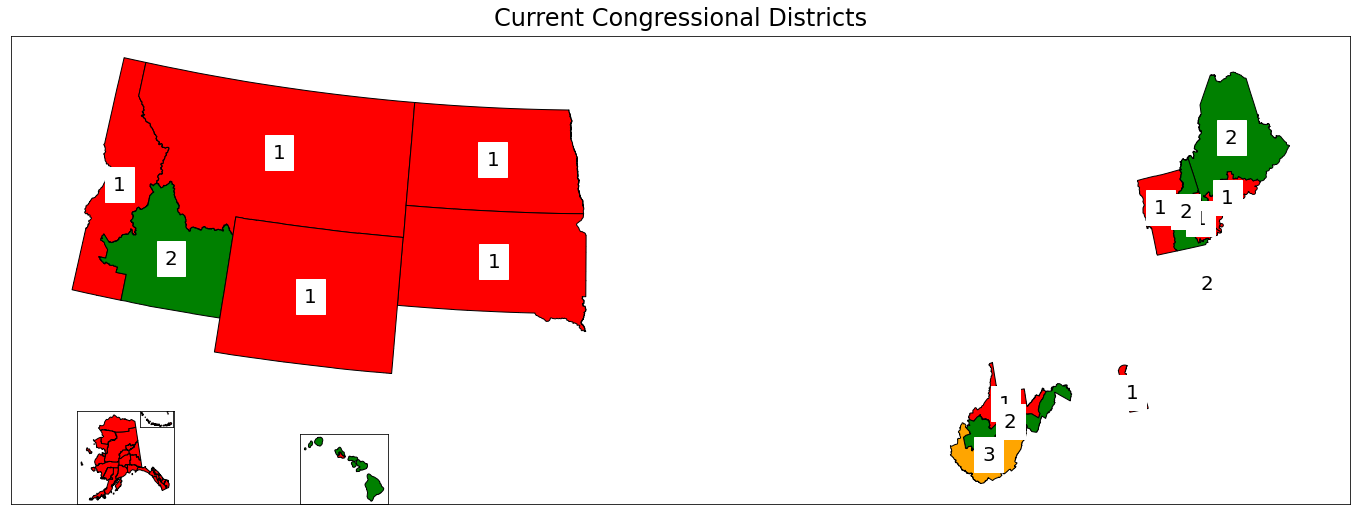

In [16]:
s = time.time()
main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "

alaska_crs = "epsg:3338"
hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "


show_tracts = False
show_water = False

print('main map...')

print('\treprojecting...')

main_map_bounds = unary_union(state_gdf[state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).geometry.tolist()).bounds
main_map_aspect_ratio = (main_map_bounds[2] - main_map_bounds[0]) / (main_map_bounds[3] - main_map_bounds[1])

fig, ax = plt.subplots(1,1,figsize=(24, 24/main_map_aspect_ratio))
ax.set_aspect('equal')


print('\tplotting...')

for this_state in state_gdf[(state_gdf['STUSPS'].isin(these_states_dict.keys())) & (state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI']))]['STUSPS'].sort_values().tolist():
    print('\t\tPlotting {0:}...'.format(this_state))
    cdlist = cd_gdf[cd_gdf['STUSAB'] == this_state]['CD116'].drop_duplicates().sort_values().tolist()
    for i in range(1, len(cdlist)+1):
        cd_gdf[
            (cd_gdf['STUSAB'] == this_state) 
            & (cd_gdf['CD116'] == i)
        ].to_crs(main_map_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black')
        annotator = i
        #this_district_geo = unary_union(cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116'] == i)].to_crs(main_map_crs).geometry.tolist())
        this_district_geo = unary_union(cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116'] == i)].to_crs(main_map_crs).geometry.tolist())
        centerpoint = (this_district_geo.centroid.x, this_district_geo.centroid.y)

        #break
        #centerpoint = (cd_gdf[cd_gdf['CD116'] == thiscd]['INTPTLON'].values[0], cd_gdf[cd_gdf['CD116'] == thiscd]['INTPTLAT'].values[0])
        ax.annotate(annotator, centerpoint, 
                    color='black', backgroundcolor='white', ha='center', va='center', fontsize=20)

if (show_tracts):
    print('\tplotting census tracts...')
    tract_gdf[tract_gdf['STATEFP'].apply(lambda x: x not in [2,15])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

if (show_water):
    print('\tplotting census tracts...')
    water_gdf[water_gdf['STATEFP'].apply(lambda x: x not in [2,15])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)



    
# #ax.legend(handles=legend_list, fontsize=10)


if (len(list(these_states_dict.keys())) == 1):
    ax.set_title('Current {0:} Congressional Districts (n = {1:.0f})'.format(
        list(these_states_dict.keys())[0], 
        these_states_dict[list(these_states_dict.keys())[0]]['seats_old']
    ), fontsize=24, y=1.01)
else:
    ax.set_title('Current Congressional Districts', fontsize=24, y=1.01)

# # # # ax.tick_params(axis='both', labelsize=20)

# # # # # print('saving figure...')
# # # # # fig.savefig('{0:}{1:}_old.png'.format(script_dir, list(these_states_dict.keys())[0].lower()), format='png', dpi=300, bbox_inches='tight', facecolor='white')

# # # #plt.show()
# # e = time.time()
# # g += (e-s)
# # print('Done plotting in {0:.0f} minutes {1:.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))
# # #[inset['axes_position'][0], inset['axes_position'][1], inset['axes_size'][0], inset['axes_size'][1]]

# # state_gdf[state_gdf['NAME'].apply(lambda x: x not in ['Alaska', 'Hawaii'])].to_crs(main_map_crs).plot(ax=ax)

print('AK inset...')
print('\treprojecting Alaska...')
ak_map_bounds = geopandas.GeoDataFrame(data=[[unary_union(county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAMELSAD'].apply(lambda x: 'aleutians west' not in x.lower()))].geometry.tolist())]], columns=['geometry'], crs=county_gdf.crs, geometry='geometry').to_crs(alaska_crs).bounds.values[0].tolist()
ak_map_aspect_ratio = (ak_map_bounds[2] - ak_map_bounds[0]) / (ak_map_bounds[3] - ak_map_bounds[1])

ak_inset_ax = ax.inset_axes([-0.049,0,ak_map_aspect_ratio*0.2,0.2])

#ak_inset_ax = ax.inset_axes([0,0,ak_map_aspect_ratio*1,1])

print('\t\treprojecting Aleutians West...')
aleutians_west_map_bounds = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Aleutians West')
].to_crs(alaska_crs).geometry.tolist()).bounds

aleutians_west_map_aspect_ratio = (aleutians_west_map_bounds[2] - aleutians_west_map_bounds[0]) / (aleutians_west_map_bounds[3] - aleutians_west_map_bounds[1])

# aleutians_inset_ax = ak_inset_ax.inset_axes([-0.325,-0.015,0.2*aleutians_west_map_aspect_ratio,0.2])   # to show Aletuians West in their actual geographic spot
aleutians_inset_ax = ak_inset_ax.inset_axes([0.59,0.825,0.175*aleutians_west_map_aspect_ratio,0.175])

print('plotting Alaska...')
cdlist = cd_gdf[cd_gdf['STUSAB'] == 'AK']['CD116'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'AK') & (cd_gdf['CD116'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=ak_inset_ax, color=district_color_cycle[i], edgecolor='black')
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'AK') & (cd_gdf['CD116'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] == 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=aleutians_inset_ax, color=district_color_cycle[i], edgecolor='black')
# if (show_tracts):
#     print('\tplotting census tracts...')
#     tract_gdf[tract_gdf['STUSAB'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
    

print('HI inset...')
print('\treprojecting and plotting Hawaii...')
print('\t\tremoving outer islands...')
honolulu_county_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Honolulu')
].geometry.tolist())
honolulu_county_bounds = honolulu_county_geo.bounds
fixed_honolulu_county_geo = unary_union(geopandas.overlay(
    geopandas.GeoDataFrame(data=[[honolulu_county_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'), 
    geopandas.GeoDataFrame(data=[[box(-160, honolulu_county_bounds[1], honolulu_county_bounds[2], honolulu_county_bounds[3])]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'),
    how='intersection'
).geometry.tolist())
other_hawaii_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] != 'Honolulu')
].geometry.tolist())
fixed_hawaii_geo = unary_union([other_hawaii_geo, fixed_honolulu_county_geo])
fixed_hawaii_gdf = geopandas.GeoDataFrame(data=[[fixed_hawaii_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry')

hi_map_bounds = fixed_hawaii_gdf.geometry.to_crs(hawaii_crs).geometry.apply(lambda x: x.bounds).values[0]
hi_map_aspect_ratio = (hi_map_bounds[2] - hi_map_bounds[0]) / (hi_map_bounds[3] - hi_map_bounds[1])

#print(hi_map_aspect_ratio)

hi_inset_ax = ax.inset_axes([0.128,0,hi_map_aspect_ratio*0.15,0.15])

print('plotting Hawaii...')
cdlist = cd_gdf[cd_gdf['STUSAB'] == 'HI']['CD116'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'HI') & (cd_gdf['CD116'] == i)], 
        fixed_hawaii_gdf,
        #county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(hawaii_crs).plot(ax=hi_inset_ax, color=district_color_cycle[i], edgecolor='black')

for thisax in [ax, ak_inset_ax, aleutians_inset_ax, hi_inset_ax]:
    thisax.set_xticks([])
    thisax.set_yticks([])

plt.show()


In [17]:

for this_state_name, this_state in these_states_dict.items():
    if (this_state['seats_new'] == 1):
        these_states_dict[this_state_name]['target'] = -1
    else:
        these_states_dict[this_state_name]['target'] = cd_gdf[cd_gdf['STUSAB'] == this_state_name]['POP100'].sum() / this_state['seats_new']
    
    
these_states_dict
#water_gdf.head(1).T

{'AK': {'STATEFP': 2, 'seats_old': 1, 'seats_new': 1, 'target': -1},
 'WY': {'STATEFP': 56, 'seats_old': 1, 'seats_new': 1, 'target': -1},
 'ND': {'STATEFP': 38, 'seats_old': 1, 'seats_new': 1, 'target': -1},
 'SD': {'STATEFP': 46, 'seats_old': 1, 'seats_new': 1, 'target': -1},
 'DE': {'STATEFP': 10, 'seats_old': 1, 'seats_new': 1, 'target': -1},
 'VT': {'STATEFP': 50, 'seats_old': 1, 'seats_new': 1, 'target': -1},
 'HI': {'STATEFP': 15, 'seats_old': 2, 'seats_new': 2, 'target': 727635.5},
 'ID': {'STATEFP': 16, 'seats_old': 2, 'seats_new': 2, 'target': 919553.0},
 'MT': {'STATEFP': 30, 'seats_old': 1, 'seats_new': 2, 'target': 542112.5},
 'WV': {'STATEFP': 54, 'seats_old': 3, 'seats_new': 2, 'target': 896858.0},
 'RI': {'STATEFP': 44, 'seats_old': 2, 'seats_new': 2, 'target': 548689.5},
 'NH': {'STATEFP': 33, 'seats_old': 2, 'seats_new': 2, 'target': 688764.5},
 'ME': {'STATEFP': 23, 'seats_old': 2, 'seats_new': 2, 'target': 681179.5}}

In [18]:
# s = time.time()
# state_target = cd_gdf['POP100'].sum() / these_states_dict[list(these_states_dict.keys())[0]]['seats_new']
tract_gdf.loc[:, 'new_district'] = np.nan

print('states with one district...')
for this_state_name, this_state in these_states_dict.items():
    if (this_state['seats_new'] == 1):
        tract_gdf.loc[tract_gdf['STUSAB'] == this_state_name, 'new_district'] = 1


tract_gdf.groupby(['STUSAB', 'new_district'])['POP100'].sum()
#place_gdf.groupby(['STATEFP', 'CD116'])['POP100'].sum()


states with one district...


STUSAB  new_district
AK      1.0             733391
DE      1.0             989948
ND      1.0             779094
SD      1.0             886667
VT      1.0             643077
WY      1.0             576851
Name: POP100, dtype: int64

# Hawaii

In [110]:
s = time.time()
this_state = 'HI'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[:, 'new_district'] = np.nan
#print('states with one district...')
for this_state_name, this_state_data in these_states_dict.items():
    if (this_state_data['seats_new'] == 1):
        tract_gdf.loc[tract_gdf['STUSAB'] == this_state_name, 'new_district'] = 1


county_mapper_df = pandas.DataFrame(data=[    
    ['Kalawao County', 2],
    ['Kauai County', 2],
    ['Maui County', 2],
    ['Hawaii County', 2],
    ['Honolulu County', 2],
], columns=['COUNTY_NAME', 'new_district_by_county'])


place_mapper_df = pandas.DataFrame(data=[
    ['Urban Honolulu',1],
    ['East Honolulu',1],    
    ['Waimanalo Beach',1],    
    ['Waimanalo',1],    
    ['Kailua',1], 
    ['Kaneohe',1],

], columns=['NAME', 'new_district_by_place'])



print('Assigning districts by county...')


tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on='COUNTY_NAME').set_index('GEOID')['new_district_by_county']

print('Assigning districts by lat/lon...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2



print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))

for i in range(-1, nDistricts):
    tracts_here = []
    tracts_within = tract_gdf[
                (tract_gdf['STUSAB'] == this_state)
                & (tract_gdf['new_district'].isnull()) & 
                (tract_gdf.geometry.within(
                    unary_union(
                        place_mapper_gdf[
                            place_mapper_gdf['new_district_by_place'] == i
                        ].geometry.tolist())
                    )
                )
            ].index.tolist()
    
    tracts_here += tracts_within
    if (len(tracts_within) > 0):
        print('\tFinding tracts that intersect places in District {0:.0f}...'.format(i))
        print('\t\tTracts within union of places: {0:.0f}...'.format(len(tracts_within)))
    
    tracts_intersect = tract_gdf[
                (tract_gdf['STUSAB'] == this_state)
#                & (tract_gdf['new_district'].isnull())  
                & (tract_gdf.geometry.intersects(
                    unary_union(
                        place_mapper_gdf[
                            place_mapper_gdf['new_district_by_place'] == i
                        ].geometry.tolist())
                    )
                )
                & ~(tract_gdf.index.isin(tracts_within))
            ].index.tolist()
    print('\t\tTracts within union of places: {0:.0f}...'.format(len(tracts_within)))    
    if (len(tracts_intersect) > 0):
        print('\t\tTracts that intersect union of places: {0:.0f}...'.format(len(tracts_intersect)))
        #print('\n')
        cnt = 0
        for ix, thisrow in tract_gdf[tract_gdf.index.isin(tracts_intersect)].iterrows():
            cnt += 1
            if (np.mod(cnt, 10) == 0):
                print('\t\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(tracts_intersect)))
            this_tract_area = geopandas.GeoDataFrame(data=[[tract_gdf.loc[ix].geometry]], columns=['geometry'], crs=tract_gdf.crs, geometry='geometry').to_crs(epsg=equal_area_crs).geometry.area.values[0]
            intersection_area = geopandas.GeoDataFrame(data=[[tract_gdf.loc[ix].geometry]], columns=['geometry'], crs=tract_gdf.crs, geometry='geometry').to_crs(
                epsg=equal_area_crs).geometry.intersection(
                                unary_union(
                        place_mapper_gdf[
                            place_mapper_gdf['new_district_by_place'] == i
                        ].to_crs(epsg=equal_area_crs).geometry.tolist())
                    ).to_crs(epsg=equal_area_crs).geometry.area.values[0]
            intersection_pct = intersection_area / this_tract_area

            

            #tract_gdf.to_crs(epsg=equal_area_crs).loc[ix].geometry.area
            if (intersection_pct >= desired_pct_area_overlap):
                tracts_here.append(ix)
                #print('Tract {0:}: {1:,.0f} m^2, intersection area {2:,.0f} m^2 ({3:.0%})'.format(ix, this_tract_area, intersection_area, intersection_pct))
            #break
        
        print('\t\tAssigning {0:.0f} place-matching tracts in District {1:.0f}!'.format(len(tracts_here), i))
        print('\n')
        tract_gdf.loc[tracts_here, 'new_district'] = i


# # since zero-population tracts don't matter anyway, unless we need them for map clarification
# #tract_gdf.loc[tract_gdf['POP100'] == 0, 'new_district'] = np.nan

print('Assigning districts by tract number...')
# tract_gdf.loc[['1400000US12086980200'], 'new_district'] = 28   # Random zero-pop tract in south Dade County

e = time.time()
g += (e-s)

print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')



for i in range(-1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):

        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

# #tract_gdf.groupby(['STUSAB', 'new_district'])['POP100'].sum()


#these_states_dict[this_state]

getting from backup...
Assigning districts by county...
Assigning districts by lat/lon...
Assigning districts by place...
		Tracts within union of places: 0...
		Tracts within union of places: 0...
		Tracts within union of places: 0...
		Tracts that intersect union of places: 199...
			Examining tract 10 of 199...
			Examining tract 20 of 199...
			Examining tract 30 of 199...


KeyboardInterrupt: 

In [102]:
# # this_state = 'HI'
# # # tract_gdf.loc[['1400000US12099007710', '1400000US12099007754', '1400000US12099007764', '1400000US12099007757', '1400000US12099007771', '1400000US12099007776', '1400000US12099007779'], 'new_district'] = 22  # SW of West Palm Beach
# # # tract_gdf.loc[['1400000US12099004810', '1400000US12099004822', '1400000US12099005000'], 'new_district'] = 22  # SW of West Palm Beach
    
# # for i in range(-1, nDistricts+1):
# #     if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
# #         #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
# #         print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, 
# #                                                                                             tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
# #                                                                                             tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
# #                                                                                             tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))
# #place_gdf = place_gdf
# for ix, thisrow in place_gdf[
#         (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) #& (((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.x <= xlimits[1]))))& ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.y <= ylimits[1])))))
#     ].to_crs(equal_area_crs)[7:8].iterrows():
#     print('finding population of {0:}...'.format(thisrow['NAME']))
#     thepop = 0
#     within_tracts = tract_gdf[tract_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.within(thisrow.geometry))].index.tolist()
#     thepop += tract_gdf[tract_gdf.index.isin(within_tracts)]['POP100'].sum()
#     print('\tFound {0:,.0f} tracts entirely within, with population {1:,.0f}...'.format(len(tracts_within), thepop))
#     intersecting_tracts = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.intersects(thisrow.geometry)))].index.tolist()
#     print('\tFound {0:,.0f} intersecting tracts...'.format(len(intersecting_tracts)))
#     for i in range(0, len(intersecting_tracts)):
#         #if ((np.mod(i, 10) == 0) | (i == len(intersecting_tracts)-1)):
#         print('\t\tmatching tract i = {0:,.0f}...'.format(i+1))
#         total_area = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area
#         intersection_area = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(thisrow.geometry).area
#         intersection_pct = intersection_area / total_area
#         print(intersection_pct)
#     break
    
# #    print(tract_gdf[tract_gdf.index.isin(intersecting_tracts)]['POP100'].sum())
# print('Done!')


xspan = 150.00 km
aspect_ratio  = 2.50:1


plotting tracts...
plotting places...
labeling places...
plotting water areas...


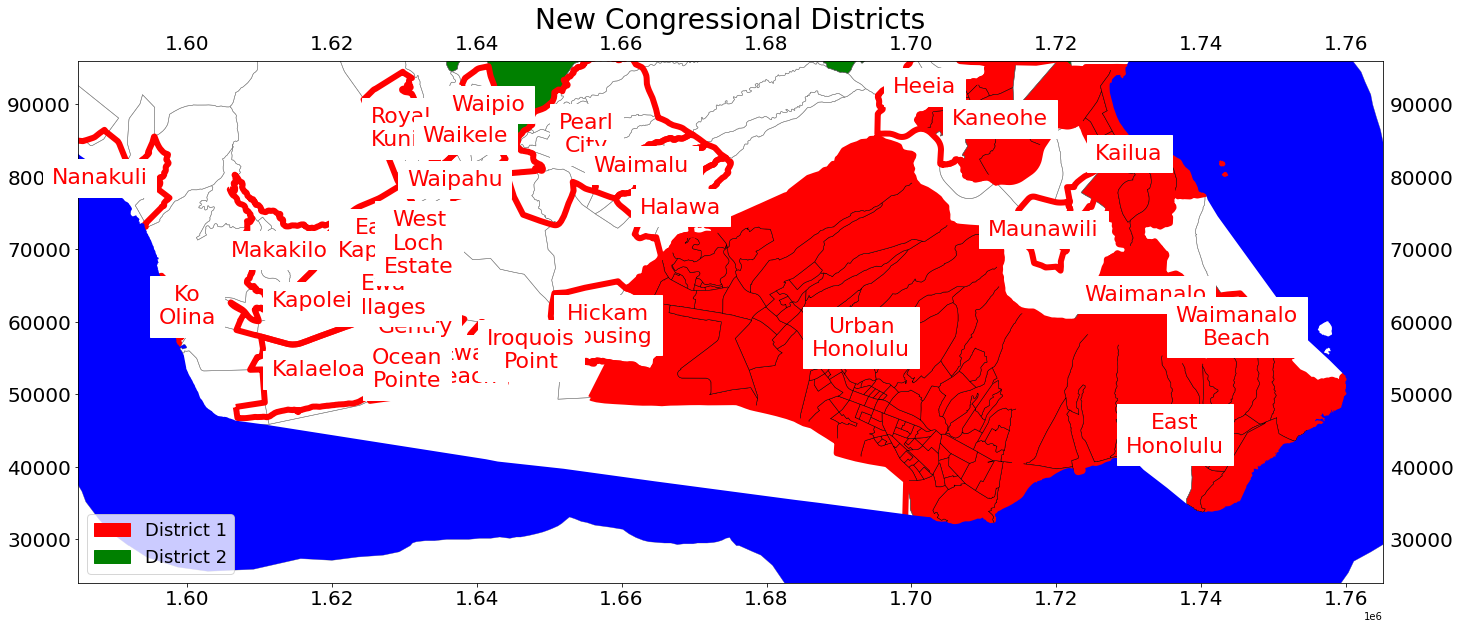



District 1: n = 483,710 (66.5% of target; overshot = -243,926)
District 2: n = 603,985 (83.0% of target; overshot = -123,650)


In [107]:
show_water = True
show_roads = False
show_small_roads = False
label_tracts = False

show_places = True
label_places = True

#show_counties = True
#label_counties = True

the_label_size = 20
the_annotation_size = 22
the_line_width = .5
the_line_width_wide = 6
the_legend_size = 18
the_title_size = 28

#bounds_counties = []

# if (len(bounds_counties) > 0):
#     xlimits = [-162, unary_union(county_gdf[county_gdf['NAME'].isin(bounds_counties)].geometry.tolist()).bounds[2]]
#     ylimits = [unary_union(county_gdf[county_gdf['NAME'].isin(bounds_counties)].geometry.tolist()).bounds[1], 23]
# else:
#     xlimits = [-161, unary_union(state_gdf[state_gdf['STUSPS'] == this_state].geometry.tolist()).bounds[2]]
#     ylimits = [unary_union(state_gdf[state_gdf['STUSPS'] == this_state].geometry.tolist()).bounds[1], 22.5]


# Hawaii    
xlimits = [800000, unary_union(state_gdf[state_gdf['STUSPS'] == this_state].to_crs(hawaii_crs).geometry.tolist()).bounds[2]]
ylimits = [unary_union(state_gdf[state_gdf['STUSPS'] == this_state].to_crs(hawaii_crs).geometry.tolist()).bounds[1], 400000]

# Oahu
xlimits = [1.55e6, 1.75e6]
ylimits = [0.01e6,0.18e6]

# South coast of Oahu
xlimits = [1.6e6,1.75e6]
ylimits = [.03e6,.09e6]
    
xspan = xlimits[1] - xlimits[0]
yspan = ylimits[1] - ylimits[0]
aspect_ratio = xspan / yspan

xbuffer = xspan * map_buffer_ratio
ybuffer = yspan * map_buffer_ratio

xlimits = [xlimits[0] - xbuffer, xlimits[1] + xbuffer] #cd_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
ylimits = [ylimits[0] - ybuffer, ylimits[1] + ybuffer] 

print('xspan = {0:,.2f} km'.format(xspan/1000))
print('aspect_ratio  = {0:,.2f}:1'.format(aspect_ratio))
print('\n')

# fig, ax = plt.subplots(1,1, figsize=(xspan*scale, yspan*scale))
fig, ax = plt.subplots(1,1,figsize=(24, 24/aspect_ratio))
ax.set_aspect('equal')

# print('plotting CBSAs...')
# cbsa_gdf[
#     ((cbsa_gdf['INTPTLON'] >= xlimits[0]) & (cbsa_gdf['INTPTLON'] <= xlimits[1]))
#     & ((cbsa_gdf['INTPTLAT'] >= ylimits[0]) & (cbsa_gdf['INTPTLAT'] <= ylimits[1]))
# ].plot(ax=ax, color='none', edgecolor='yellow')


print('plotting tracts...')

# base layer
legend_list = []
for i in range(-1,these_states_dict[this_state]['seats_new']+1):
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        #print(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum())
        tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)].to_crs(hawaii_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black', linewidth=the_line_width)#, alpha=0.25)        
        legend_list.append(mpatches.Patch(color=district_color_cycle[i], label='District {0:,.0f}'.format(i)))

tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull())].to_crs(hawaii_crs).plot(ax=ax, color='none', edgecolor='gray', lw=the_line_width)


if (label_tracts):
    print('labeling tracts...')
    for ix, thisrow in tract_gdf[
        (((tract_gdf['INTPTLON'] >= xlimits[0]) & (tract_gdf['INTPTLON'] <= xlimits[1])) & ((tract_gdf['INTPTLAT'] >= ylimits[0]) & (tract_gdf['INTPTLAT'] <= ylimits[1])))
        & (tract_gdf['new_district'].isnull())
#        & (tract_gdf['new_district'] == 6)
#        & (tract_gdf['INTPTLAT'] >= 28.9)
#             & (
#                 ((tract_gdf['INTPTLAT'] >= 39.37) & (tract_gdf['new_district'] == 2))
#                 | ((tract_gdf['INTPTLON'] <=  -76.64) & (tract_gdf['new_district'] == 1))
#               )
    ].to_crs(hawaii_crs).sort_values(by=['COUNTY_NAME', 'census_tract']).iterrows():
        print('{0:}-{1:}:\t{2:}'.format(thisrow['COUNTY_NAME'][0:3],thisrow['census_tract'], ix))
        #print('{0:}:\t{1:}'.format(thisrow['census_tract'], ix))
        annotator = '{0:}-{1:}\n{2:,.0f}'.format(thisrow['COUNTY_NAME'][0:3],thisrow['census_tract'], geo_df.loc[ix]['POP100'])
        #annotator = '{0:}\n{1:,.0f}'.format(thisrow['census_tract'], geo_df.loc[ix]['POP100'])
        centerpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
        ax.annotate(annotator, centerpoint, 
                    color='gray', backgroundcolor='white', ha='center', va='center', 
                    fontsize=the_annotation_size)

if (show_places):
    print('plotting places...')
    place_gdf[
        (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])& (((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.x <= xlimits[1]))))& ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.y <= ylimits[1])))))
    ].to_crs(hawaii_crs).plot(ax=ax, edgecolor='red', lw=the_line_width_wide, color='none')

if (label_places):
    print('labeling places...')
    for ix, thisrow in place_gdf[
        (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])& (((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.x <= xlimits[1]))))& ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.y <= ylimits[1])))))
    ].to_crs(hawaii_crs).iterrows():
#        print(thisrow['NAME'])
        annotator = thisrow['NAME'].replace(' ','\n')
        centerpoint = [thisrow.geometry.centroid.x, thisrow.geometry.centroid.y]
        ax.annotate(annotator, centerpoint, 
                    color='red', backgroundcolor='white', ha='center', va='center', 
                    fontsize=the_annotation_size)

if (show_water):
    print('plotting water areas...')
    water_gdf[water_gdf['STUSAB'] == this_state].to_crs(hawaii_crs).plot(ax=ax, color='blue')

    
# if (show_roads):
#     print('plotting roads...')
#     if (show_small_roads):
#         print('\tsmall...')
#         roads_gdf[~roads_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax, color='black', linewidth=0.1)
#     print('\tlarge...')
#     roads_gdf[roads_gdf['RTTYP'] == 'C'].plot(ax=ax, color='black', linewidth=0.25) 
#     roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=0.5) 
#     roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=0.75)     
#     roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax, color='black', linewidth=1) 

# if (show_counties):
#     print('\n')
#     print('plotting state and county borders...')
#     if (len(bounds_counties) > 0):   
#         county_gdf[county_gdf['NAME'].isin(bounds_counties)].plot(ax=ax, color='none', edgecolor='black', linewidth=2)
#     else:
#         county_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=2)
#     state_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width_wide)
# if (label_counties):
#     print('labeling counties...')
#     for ix, thisrow in county_gdf[
#         (county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
#         & (
#             ((county_gdf['INTPTLON'] >= xlimits[0]) & (county_gdf['INTPTLON'] <= xlimits[1])) 
#             & ((county_gdf['INTPTLAT'] >= ylimits[0]) & (county_gdf['INTPTLAT'] <= ylimits[1])))
#     ].iterrows():
#         ax.annotate('{0:}'.format(thisrow['NAME']), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), color='gray', backgroundcolor='white', ha='center', va='center',  fontsize=the_annotation_size)

plt.xlim(xlimits)
plt.ylim(ylimits)

#ax.set_xticks(np.arange(xlimits[0], xlimits[1], xspan/10))#, fontsize=the_label_size)
#ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_tick_params(labelbottom=True, labeltop=True, labelsize=the_label_size)

#ax.set_yticks(np.arange(27.8, 28.8, 0.025))
ax.yaxis.set_tick_params(labelleft=True, labelright=True, labelsize=the_label_size)

ax.legend(handles=legend_list, fontsize=the_legend_size, loc='lower left')

if (len(list(these_states_dict.keys())) == 1):
    plt.title('New {0:} Congressional Districts (n = {1:.0f})'.format(
        list(these_states_dict.keys())[0], 
        these_states_dict[list(these_states_dict.keys())[0]]['seats_new']
    ), fontsize=the_title_size)
else:    
    plt.title('New Congressional Districts', fontsize=the_title_size)



plt.show()
print('\n')
for i in range(1, these_states_dict[this_state]['seats_new']+1):
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, 
                                                                                            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
                                                                                            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
                                                                                            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target)
             )


In [22]:

#county_gdf[(
county_gdf[county_gdf['STATEFP'] == these_states_dict['HI']['STATEFP']]['NAME']
#].groupby('NAME')['POP100'].sum()
#county_gdf.columns

GEOID
15003    Honolulu
15005     Kalawao
15007       Kauai
15009        Maui
15001      Hawaii
Name: NAME, dtype: object

In [23]:
# new_district_shapes_gdf = geopandas.GeoDataFrame(data=None, columns=['new_district', 'geometry'], crs=tract_gdf.crs, geometry='geometry').set_index('new_district')
# for i in range(1, these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
#     print('merging tract shapes get district {0:,.0f} boundaries...'.format(i))
#     new_district_shapes_gdf.loc[i, 'geometry'] = unary_union(tract_gdf[tract_gdf['new_district'] == i].geometry.tolist())    
# #new_district_shapes_gdf = new_district_shapes_gdf.reset_index()
    
# xlimits = cd_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# ylimits = cd_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = cd_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = cd_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]

# fig, ax = plt.subplots(1,1, figsize=(xspan*scale, yspan*scale))
# ax.set_aspect('equal')
# #thedistricts = [x for x in cd_gdf['CD116'].drop_duplicates().tolist()]

# thedistricts = list(set([int(x) for x in cd_gdf['CD116'].drop_duplicates().tolist()]))

# legend_list = []

# print('ploting congressional districts...')
# for thiscd in thedistricts:
#     print('Plotting district {0:.0f}...'.format(thiscd))
#     new_district_shapes_gdf[new_district_shapes_gdf.index == thiscd].plot(ax=ax, color=district_color_cycle[thiscd])
#     #cd_gdf[cd_gdf['CD116'] == thiscd].to_crs(epsg=theproj).plot(ax=ax, color=district_color_cycle[thiscd])
#     #cd_gdf[cd_gdf['CD116'] == thiscd].plot(ax=ax, color=district_color_cycle[thiscd])
#     legend_list.append(mpatches.Patch(color=district_color_cycle[thiscd], label='District {0:,.0f}'.format(thiscd)))
    
    
#     annotator = thiscd #parse_road_name(thisrow['FULLNAME'])
#     centerpoint = (unary_union(new_district_shapes_gdf[new_district_shapes_gdf.index == thiscd].geometry.tolist()).centroid.x, unary_union(new_district_shapes_gdf[new_district_shapes_gdf.index == thiscd].geometry.tolist()).centroid.y)
#     #centerpoint = (new_district_shapes_gdf[new_district_shapes_gdf.index == thiscd]['INTPTLON'].values[0], cd_gdf[cd_gdf['CD116'] == thiscd]['INTPTLAT'].values[0])
#     ax.annotate(annotator, centerpoint, 
#                 color='black', backgroundcolor='white', ha='center', va='center', fontsize=2.25*scale)
    
# print('ploting census tracts...')
# tract_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=0.0625*scale)

# if (show_water):
#     print('ploting water areas...')
#     water_gdf.plot(ax=ax, color='blue')
    
# #state_gdf.to_crs(epsg=theproj).plot(ax=ax, color='none', edgecolor='black', lw=0.25*scale)
# state_gdf.plot(ax=ax, color='none', edgecolor='black', lw=0.25*scale)
    
# ax.legend(handles=legend_list, fontsize=2.25*scale)

# if (len(list(these_states_dict.keys())) == 1):
#     plt.title('Current {0:} Congressional Districts (n = {1:.0f})'.format(
#         list(these_states_dict.keys())[0], 
#         these_states_dict[list(these_states_dict.keys())[0]]['seats_old']
#     ), fontsize=3*scale)
# else:
#     plt.title('Current Congressional Districts', fontsize=3*scale)

# plt.xticks(fontsize=2*scale)
# plt.yticks(fontsize=2*scale)

# plt.show()

# # #fig.get_size_inches()
# #cd_gdf[cd_gdf['CD116'] == 'ZZ']


